## 0) Setup cell (imports, paths, helpers)

In [8]:
try:
    import yfinance as yf  # noqa
except ModuleNotFoundError:
    !pip install yfinance

In [9]:
from datetime import datetime, timedelta
import pathlib
import pandas as pd
import numpy as np

In [10]:
PROJECT_ROOT = pathlib.Path.cwd().resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_RAW

PosixPath('/Users/mengmeng/bootcamp_Shuchen_Meng/homework/homework4/data/raw')

In [11]:
def ts_tag():
    return datetime.now().strftime("%Y%m%d-%H%M")

def save_csv(df: pd.DataFrame, prefix: str, parts: dict) -> pathlib.Path:
    """Save df to data/raw/ as prefix_k1-v1_k2-v2_<timestamp>.csv"""
    stem = prefix + "_" + "_".join(f"{k}-{v}" for k,v in parts.items())
    path = DATA_RAW / f"{stem}_{ts_tag()}.csv"
    df.to_csv(path, index=False)
    return path

def validate_df(
    df: pd.DataFrame,
    required_cols: list[str],
    numeric_cols: list[str] | None = None,
    date_cols: list[str] | None = None,
    min_rows: int = 1,
):
    # columns present
    missing = [c for c in required_cols if c not in df.columns]
    assert not missing, f"Missing required columns: {missing}"

    # coerce types
    if numeric_cols:
        for c in numeric_cols:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")
    if date_cols:
        for c in date_cols:
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors="coerce", utc=False)

    # NA counts + shape
    na_counts = df[required_cols].isna().sum().to_dict()
    assert len(df) >= min_rows, f"Too few rows: {len(df)}"
    return na_counts

## 1) Choose ticker & date range

In [12]:
USE_TICKER = "SPY"   # change to "BTC-USD" if you want bitcoin

end = datetime.today().date()
start = end - timedelta(days=180)   # ~ last 6 months
print(f"Downloading {USE_TICKER} from {start} to {end}")

In [43]:
# Download daily data
df = yf.download(USE_TICKER, start=start.isoformat(), end=end.isoformat(),
                 interval="1d", progress=False)

/var/folders/mm/zd5mx6qs3wz9922pdygh0dzc0000gn/T/ipykernel_28848/3678397884.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(USE_TICKER, start=start.isoformat(), end=end.isoformat(),


In [44]:
if df is None or len(df) == 0:
    raise RuntimeError("No data returned. Try another ticker or wider date range.")

In [45]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2025-02-24,593.663818,599.449267,592.948062,598.445254,50737200
2025-02-25,590.711426,594.339777,586.059223,593.604180,58266500
2025-02-26,591.009644,596.019755,588.345564,592.391404,43321600
2025-02-27,581.575989,594.469005,581.178400,593.305909,74196700
2025-02-28,590.651794,591.188566,578.981515,582.082984,88744100


In [49]:
def normalize_yf(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a tidy DataFrame with:
      single-ticker: date, open, high, low, close, adj_close, volume
      multi-ticker : date, ticker, open, high, low, close, adj_close, volume
    Works for yfinance outputs with either flat or MultiIndex columns.
    """
    if isinstance(df.columns, pd.MultiIndex):
        # Multi-ticker case → stack tickers into a 'ticker' column
        out = df.stack(level=-1).reset_index()              # Date, ticker, OHLCV...
        out = out.rename(columns={"Date": "date", out.columns[1]: "ticker"})
    else:
        # Single-ticker case → just make date a column
        out = df.reset_index().rename(columns={"Date": "date"})

    # standardize column names
    out.columns = [str(c).strip().lower().replace(" ", "_") for c in out.columns]
    # unify adj close naming
    if "adj_close" not in out.columns and "adj_close" in [c.replace(" ", "_").lower() for c in out.columns]:
        pass  # already handled by lower/replace
    if "adj_close" not in out.columns and "adj_close" not in out.columns and "adj_close" in out.columns:
        pass  # defensive
    if "adj_close" not in out.columns and "adj close" in df.columns:
        out = out.rename(columns={"adj close": "adj_close"})

    # keep canonical set if present
    keep = [c for c in ["date", "ticker", "open", "high", "low", "close", "adj_close", "volume"] if c in out.columns]
    out = out[keep]
    return out

In [50]:
tidy = normalize_yf(df)
tidy.head()

/var/folders/mm/zd5mx6qs3wz9922pdygh0dzc0000gn/T/ipykernel_28848/3728674468.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  out = df.stack(level=-1).reset_index()              # Date, ticker, OHLCV...


,date,ticker,open,high,low,close,volume
0,2025-02-24,SPY,598.445254,599.449267,592.948062,593.663818,50737200
1,2025-02-25,SPY,593.604180,594.339777,586.059223,590.711426,58266500
2,2025-02-26,SPY,592.391404,596.019755,588.345564,591.009644,43321600
3,2025-02-27,SPY,593.305909,594.469005,581.178400,581.575989,74196700
4,2025-02-28,SPY,582.082984,591.188566,578.981515,590.651794,88744100


In [57]:
tidy.columns = [str(c) for c in tidy.columns]
# Keep a standard OHLCV set when present
keep = [c for c in ["date","open","high","low","close","adj_close","volume"] if c in tidy.columns]
tidy = tidy[keep].copy()
tidy.head()

,date,open,high,low,close,volume
0,2025-02-24,598.445254,599.449267,592.948062,593.663818,50737200
1,2025-02-25,593.604180,594.339777,586.059223,590.711426,58266500
2,2025-02-26,592.391404,596.019755,588.345564,591.009644,43321600
3,2025-02-27,593.305909,594.469005,581.178400,581.575989,74196700
4,2025-02-28,582.082984,591.188566,578.981515,590.651794,88744100


In [58]:
required = [c for c in ["date","open","high","low","close","volume"] if c in tidy.columns]
na_info = validate_df(
    tidy,
    required_cols=required,
    numeric_cols=[c for c in ["open","high","low","close","adj_close","volume"] if c in tidy.columns],
    date_cols=["date"],
    min_rows=10,
)
print("NA counts:", na_info)

out_path = save_csv(df, prefix="api", parts={"SRC":"yfinance","TICKER":USE_TICKER.replace('-','')})
print("Saved to:", out_path)

NA counts: {'date': 0, 'open': 0, 'high': 0, 'low': 0, 'close': 0, 'volume': 0}
Saved to: /Users/mengmeng/bootcamp_Shuchen_Meng/homework/homework4/data/raw/api_SRC-yfinance_TICKER-SPY_20250822-0124.csv


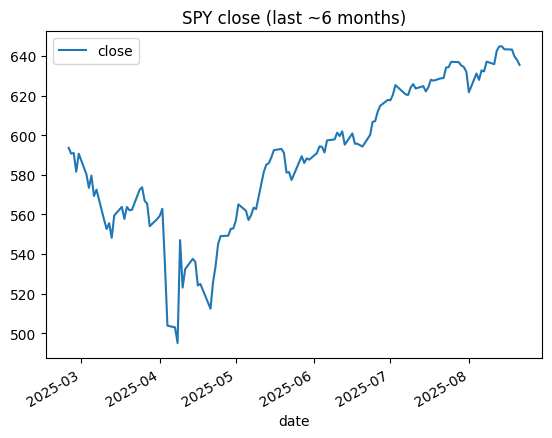

In [60]:
import matplotlib.pyplot as plt

tidy.plot(x="date", y="close", title=f"{USE_TICKER} close (last ~6 months)")
plt.show()

In [61]:
!git add .

In [62]:
!git commit -m "Homewor4:Data Acquisition and Ingestion"

[main db54184] Homewor4:Dat Acquisition and Ingestion
 2 files changed, 801 insertions(+)
 create mode 100644 homework/homework4/data/raw/api_SRC-yfinance_TICKER-SPY_20250822-0124.csv
 create mode 100644 homework/homework4/homework4.ipynb


In [63]:
!git push

Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 10 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (8/8), 6.17 KiB | 6.17 MiB/s, done.
Total 8 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:mengmeng12/bootcamp_Shuchen_Meng.git
   1bc7aff..db54184  main -> main
